In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import lightgbm as lgb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.model_selection import GroupKFold
import random
from sklearn.preprocessing import LabelEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if "KAGGLE_URL_BASE" in os.environ:
    raw_path = "/kaggle/input/cmi-detect-behavior-with-sensor-data"
else:
    raw_path = "../data/raw"

seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [220]:
from src.feature_engineer import rotation_feature_engineer, accelrometer_feature_engineer
from src.data_cleaning import clean_df, remove_gravity, normalize_sequence_count
from src.utils.model_utils import train_model, evaluate_model, normalize_tensor, evaluate_fold, store_results
from src.utils.visualize_utils import get_avg_fold, plot_cm

In [173]:
class SensorDataset(Dataset):
    def __init__(self, features: torch.Tensor, targets: torch.Tensor, should_augment=False):
        super().__init__()
        self.data = features
        self.targets = targets
        self.should_augment = should_augment

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]

        if self.should_augment:
            raise NotImplementedError("Augmentations not implemented")

        return x, y

    def __len__(self):
        return len(self.data)


def sensor_collate_train_fn(batch, n_imu, n_classes=18, mixup_alpha=0.4):
    x_batch = torch.stack([item[0] for item in batch])
    y_batch = torch.stack([item[1] for item in batch])

    # ---- Mixup Augmentation ----
    lam = np.random.beta(mixup_alpha, mixup_alpha)
    shuffled_indices = torch.randperm(x_batch.shape[0])

    x2 = x_batch[shuffled_indices]
    x_mixed = lam * x_batch + (1 - lam) * x2

    y1 = nn.functional.one_hot(y_batch, num_classes=n_classes)
    y2 = y1[shuffled_indices]
    y_mixed = lam * y1 + (1 - lam) * y2
    # ---- End Mixup ----

    # ---- Randomly disable non IMU ----
    shuffled_indices = torch.randperm(x_batch.shape[0] // 2)
    x_mixed[shuffled_indices, n_imu:, :] = -1
    # ---- End Randomly disable non IMU ----

    return x_mixed, y_mixed

dummy_input = torch.randn([64, 20, 100])
dummy_targets = torch.randint(0, 5, [64])

dataset = SensorDataset(dummy_input, dummy_targets)
dataloder = DataLoader(dataset, 8, shuffle=True, collate_fn=lambda batch: sensor_collate_train_fn(batch, n_imu=5))
for x, y in dataloder:
    print(y.shape)

torch.Size([8, 18])
torch.Size([8, 18])
torch.Size([8, 18])
torch.Size([8, 18])
torch.Size([8, 18])
torch.Size([8, 18])
torch.Size([8, 18])
torch.Size([8, 18])


In [143]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

tof_of_interest = ["tof_1_v20", "tof_2_v26", "tof_3_v17", "tof_4_v5"]
full_df = full_df.drop(columns=[col for col in full_df.columns if col not in tof_of_interest and  col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_2_v26,tof_3_v17,tof_4_v5,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,122.0,57.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,124.0,68.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,133.0,97.0,107.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,151.0,113.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,207.0,121.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,62.0,219.0,93.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,58.0,216.0,82.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,56.0,208.0,83.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,59.0,210.0,91.0,1,30,0,1,186.0,55,30.0


In [180]:
cleaned_df, target_gestures = clean_df(full_df, drop_rot_na=True, drop_thm_na=False, min_gesture_count=26, max_gesture_count=38)
cleaned_df = remove_gravity(cleaned_df)
cleaned_df = normalize_sequence_count(cleaned_df)

cleaned_df = rotation_feature_engineer(cleaned_df)
cleaned_df = accelrometer_feature_engineer (cleaned_df)

cleaned_df

[rot_na] Remaining: 255817/255817 (-0, 0.0% dropped)
[gesture_len outliers] Remaining: 241893/255817 (-13924, 5.4% dropped)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,angular_vel_z,angular_speed,fft_linear_acc_x,fft_linear_acc_y,fft_linear_acc_z,acc_mag,jerk_acc_x,jerk_acc_y,jerk_acc_z,jerk_mag
0,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,0.000000,0.000000,5297.395963,10736.157005,832.627230,9.924192,0.000000,0.000000,0.000000,0.000000
1,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,0.866171,5.950586,18.005330,48.635115,11.711802,10.113299,0.106349,-0.080353,0.297627,0.326111
2,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,-6.557898,7.828564,40.580388,56.754995,15.324921,10.536305,0.644451,0.673234,0.322615,0.986226
3,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,-4.311011,17.631206,139.285640,2.877701,9.937450,9.782531,0.189992,-1.107950,-0.266803,1.155350
4,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,-0.930412,4.551592,9.835400,8.273737,7.254863,9.925453,-0.723718,-0.259408,0.076626,0.772614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296015,SEQ_065531_000052,Non-Target,SEQ_065531,54,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,0.130400,9.145770,1.647547,10.574324,0.000000,0.000000,0.000000,0.000000
296016,SEQ_065531_000052,Non-Target,SEQ_065531,55,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,5.795799,1.203730,5.355061,10.574324,0.000000,0.000000,0.000000,0.000000
296017,SEQ_065531_000052,Non-Target,SEQ_065531,56,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,3.683352,42.347044,15.153375,10.574324,0.000000,0.000000,0.000000,0.000000
296018,SEQ_065531_000052,Non-Target,SEQ_065531,57,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,4.269531,...,0.000000,0.000000,4.299387,6.912813,12.292207,10.574324,0.000000,0.000000,0.000000,0.000000


In [235]:
imu_features = [
    # "acc_x",
    # "acc_y",
    # "acc_z",
    "linear_acc_x",
    "linear_acc_y",
    "linear_acc_z",
    # "acc_mag",
    "linear_acc_mag",
    "fft_linear_acc_x",
    "fft_linear_acc_y",
    "fft_linear_acc_z",
    # "jerk_acc_x",
    # "jerk_acc_y",
    # "jerk_acc_z",
    "jerk_mag",
    "rotvec_x",
    "rotvec_y",
    "rotvec_z",
    "rot_angle",
    "angular_vel_x",
    "angular_vel_y",
    "angular_vel_z",
    "angular_speed",
]

non_imu_features = [
    "tof_1_v20",
    "thm_2",
    "thm_4",
    "thm_5",
]

feautures_of_interest = imu_features + non_imu_features

sequence_groups = cleaned_df.groupby("sequence_id")
gesture_df = sequence_groups["gesture"].first()
encoder = LabelEncoder().fit(gesture_df)


# full time lenght features
features_full_seq = np.array([group for _, group in sequence_groups[feautures_of_interest]], dtype=np.float32)  # N x n_timesteps x n_features
features_full_seq = torch.tensor(features_full_seq.transpose(0, 2, 1).copy())  # N x n_features x n_timestpes

target_np = encoder.transform(gesture_df).astype(np.int64)  # type: ignore
target_tensor = torch.tensor(target_np)

target_df = cleaned_df[cleaned_df['sequence_type'] == 'Target']['gesture']
target_gestures_encoded = torch.tensor(encoder.transform(target_df))

features_full_seq.shape, target_tensor.shape

(torch.Size([7790, 20, 38]), torch.Size([7790]))

In [62]:
from src.model import GaussianNoise, ReSEBlock, LSTMBlock, GRUBlock, AttentionBlock


class FullModel(nn.Module):
    def __init__(self, in_channels, n_imu_channels, n_classes):
        super().__init__()

        self.in_channels = in_channels
        self.n_imu_channels = n_imu_channels
        cnn_out_size = 128 + 64

        self.gaussian_layer = GaussianNoise(stddev=0.09)

        self.imu_branch = nn.Sequential(
            ReSEBlock(n_imu_channels, 64, stride=2),
            ReSEBlock(64, 128, stride=2),
        )

        self.non_imu_branch = nn.Sequential(
            ReSEBlock(in_channels - n_imu_channels, 32, stride=2),
            ReSEBlock(32, 64, stride=2),
        )

        self.lstm_layer = LSTMBlock(cnn_out_size, hidden_dim=cnn_out_size, layer_dim=1)  # 64 + 64 // 2
        self.gru_layer = GRUBlock(cnn_out_size, hidden_dim=cnn_out_size, layer_dim=1)

        self.temporal_attention = nn.Sequential(
            AttentionBlock(in_channels=4 * cnn_out_size),
        )

        self.shortcut_branch = nn.Sequential(
            GaussianNoise(stddev=0.09),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(cnn_out_size, 16),
            nn.ELU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(4 * cnn_out_size + 16, 256),  # Match author's layers
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes),
        )

    def forward(self, x: torch.Tensor):
        """
        X shape: N x n_features x time_steps
        """
        x_imu = x[:, : self.n_imu_channels, :]
        x_non_imu = x[:, self.n_imu_channels :, :]

        x_imu = self.gaussian_layer(x_imu)
        if not torch.allclose(x_non_imu, torch.tensor(-1.0)):
            x_non_imu = self.gaussian_layer(x_non_imu)

        out_imu_cnn: torch.Tensor = self.imu_branch(x_imu)  # B x F_imu x (T // n)
        out_non_imu_cnn: torch.Tensor = self.non_imu_branch(x_non_imu)  # B x F - F_imu x (T // n)
        out_cnn = torch.cat([out_imu_cnn, out_non_imu_cnn], dim=1)  # B x F X new_T

        out_recurrent = out_cnn.transpose(2, 1)  # B x (T // n) x F
        out_lstm = self.lstm_layer(out_recurrent)  # B x (T // n) x (hidden_dim * 2)
        out_gru = self.gru_layer(out_recurrent)  # B x T_cnn_out x (hidden_dim * 2)
        out_recurrent = torch.cat([out_lstm, out_gru], dim=2)  # B x T x F
        out_recurrent = self.temporal_attention(out_recurrent)  # B x F

        out_shortcut = self.shortcut_branch(out_cnn)  # B x 16
        out = torch.cat([out_recurrent, out_shortcut], dim=1)

        y_pred = self.fc(out)

        return y_pred

dummy_input = torch.rand(64, len(feautures_of_interest), 35)  # B x F x T
dummy_model = FullModel(in_channels=dummy_input.shape[1], n_imu_channels=len(imu_features), n_classes=len(encoder.classes_))
dummy_model(dummy_input).shape
# dummy_attention_model = AttentionBlock(35)
# dummy_attention_model(dummy_input).shape # expected output: 64 x 35


torch.Size([64, 18])

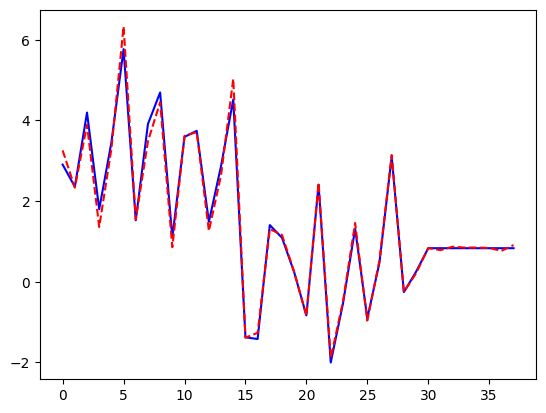

In [63]:
noise_block = GaussianNoise(0.09)
sample = features_full_seq[21,1, :]
sample_noised = noise_block(sample)

plt.plot(range(len(sample)), sample, 'b')
plt.plot(range(len(sample)), sample_noised, 'r--')

In [65]:
# Initialize results storage
results = {
    "test_full": {},
    "train_full": {},
    "test_imu_only": {},
    "train_imu_only": {},
}

n_splits = 5
gkf = GroupKFold(n_splits)
subject_per_sequence = np.array([group.iloc[0] for _, group in sequence_groups["subject"]])
n_features = features_full_seq.shape[1]
batch_size = 64
n_epochs = 1
test_subjects = []

for fold, (train_indices, test_indices) in enumerate(gkf.split(X=features_full_seq, y=target_tensor, groups=subject_per_sequence)):
    print(f"\n------FOLD {fold + 1}/{n_splits}------\n")
    if fold >= 3:
        break

    test_subjects.append(np.unique(subject_per_sequence[test_indices]))

    # Prepare data
    X_train, y_train = features_full_seq[train_indices], target_tensor[train_indices]
    X_test, y_test = features_full_seq[test_indices], target_tensor[test_indices]
    X_train = normalize_tensor(X_train)
    X_test = normalize_tensor(X_test)

    dataset_train = SensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: sensor_collate_train_fn(batch, len(imu_features)))

    # Train model
    model = FullModel(in_channels=n_features, n_imu_channels=len(imu_features), n_classes=len(encoder.classes_)).to(device)
    model.train()
    train_model(model, dataloader_train, n_epochs, True, lr=5e-3, weight_decay=3e-4)

    # Evaluate model
    with torch.no_grad():
        model.eval()

        # Test evaluations
        store_results(results["test_full"], evaluate_fold(model, X_test, y_test, target_gestures_encoded, encoder))
        store_results(results["test_imu_only"], evaluate_fold(model, X_test, y_test, target_gestures_encoded, encoder, feature_mask=len(imu_features)))

        # Train evaluations
        store_results(results["train_full"], evaluate_fold(model, X_train, y_train, target_gestures_encoded, encoder))
        store_results(results["train_imu_only"], evaluate_fold(model, X_train, y_train, target_gestures_encoded, encoder, feature_mask=len(imu_features)))

    print(f"test macro with full: {results['test_full']['f1_macro'][-1]:.3f}, train macro: {results['train_full']['f1_macro'][-1]:.3f}")
    print(f"test macro with only imu: {results['test_imu_only']['f1_macro'][-1]:.3f}, train macro: {results['train_imu_only']['f1_macro'][-1]:.3f}")


------FOLD 1/5------

0 - loss_avg: 2.3930, lr: 0.005000
test macro with full: 0.323, train macro: 0.311
test macro with only imu: 0.227, train macro: 0.231

------FOLD 2/5------

0 - loss_avg: 2.3836, lr: 0.005000
test macro with full: 0.295, train macro: 0.329
test macro with only imu: 0.242, train macro: 0.249

------FOLD 3/5------

0 - loss_avg: 2.3941, lr: 0.005000
test macro with full: 0.271, train macro: 0.289
test macro with only imu: 0.222, train macro: 0.240

------FOLD 4/5------



CNN FOLD SCORES
test_full - macro: 0.296, binary: 0.902, competition: 0.599
train_full - macro: 0.310, binary: 0.914, competition: 0.612
test_imu_only - macro: 0.230, binary: 0.851, competition: 0.541
train_imu_only - macro: 0.240, binary: 0.861, competition: 0.551


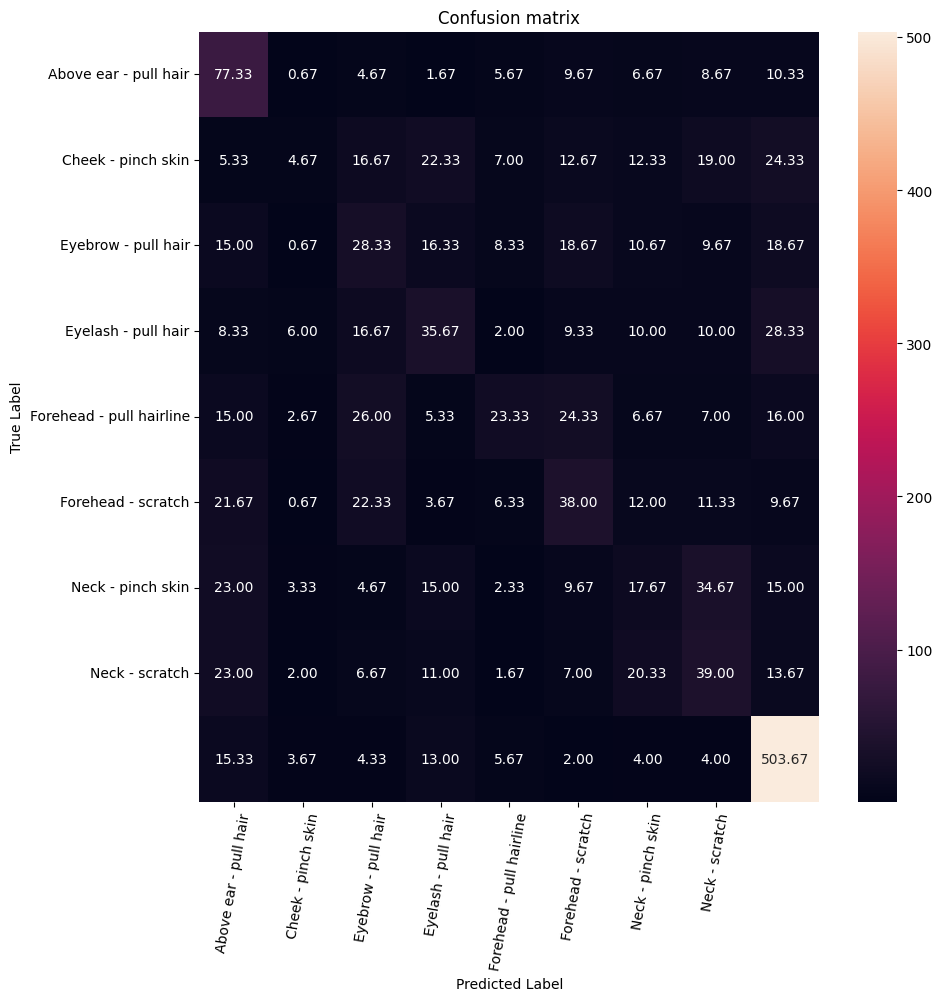

In [67]:
print("CNN FOLD SCORES")
for eval_type, scores in results.items():
    avg_scores = {metric: np.mean(values) for metric, values in scores.items() if metric != 'confusion_matrix'}
    print(f'{eval_type} - macro: {avg_scores["f1_macro"]:.3f}, binary: {avg_scores["f1_binary"]:.3f}, competition: {avg_scores["competition_evaluation"]:.3f}')

# Plot confusion matrix for test_full
avg_cm = np.mean(results['test_full']['confusion_matrix'], axis=0)
plot_cm(avg_cm, np.array(encoder.classes_), target_gestures_encoded.unique())